# Import the data 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import missingno as msno
import math

In [3]:
df = pd.read_csv("DACE_2023.csv", header=0, delimiter=',', dtype={'uspc': str, 'patent': str, 'appyear': str, 'grantyear': str})
df

,firm_id,firm_name,patent,appyear,grantyear,claims,backward_citations,forward_citations,uspc,pct_forw5_year
0,g028678,actel corp,6192086,2000,2001,4,3,6,375,55
1,g028678,actel corp,6227890,2000,2001,10,4,2,439,23
2,g028678,actel corp,6268743,2000,2001,1,2,13,326,78
3,g028678,actel corp,6285212,2000,2001,1,3,7,326,60
4,g028678,actel corp,6295148,2000,2001,2,4,34,359,94
...,...,...,...,...,...,...,...,...,...,...
103046,g061737,zoran corp,8102444,2009,2012,18,3,2,348,61
103047,g061737,zoran corp,8106972,2009,2012,17,1,0,348,1
103048,g061737,zoran corp,8120669,2009,2012,21,30,4,348,79
103049,g061737,zoran corp,7986326,2010,2011,23,26,1,345,48


# EDA

In [4]:
round(df.describe(),2)

,claims,backward_citations,forward_citations,pct_forw5_year
count,103051.00,103051.00,103051.00,103051.00
mean,21.27,21.10,6.74,48.80
std,13.12,50.25,13.92,33.59
min,1.00,0.00,0.00,1.00
25%,14.00,4.00,1.00,17.00
50%,20.00,8.00,3.00,54.00
75%,25.00,18.00,7.00,79.00
max,418.00,1545.00,429.00,100.00


In [5]:
df.uspc.nunique()

397

<AxesSubplot: >

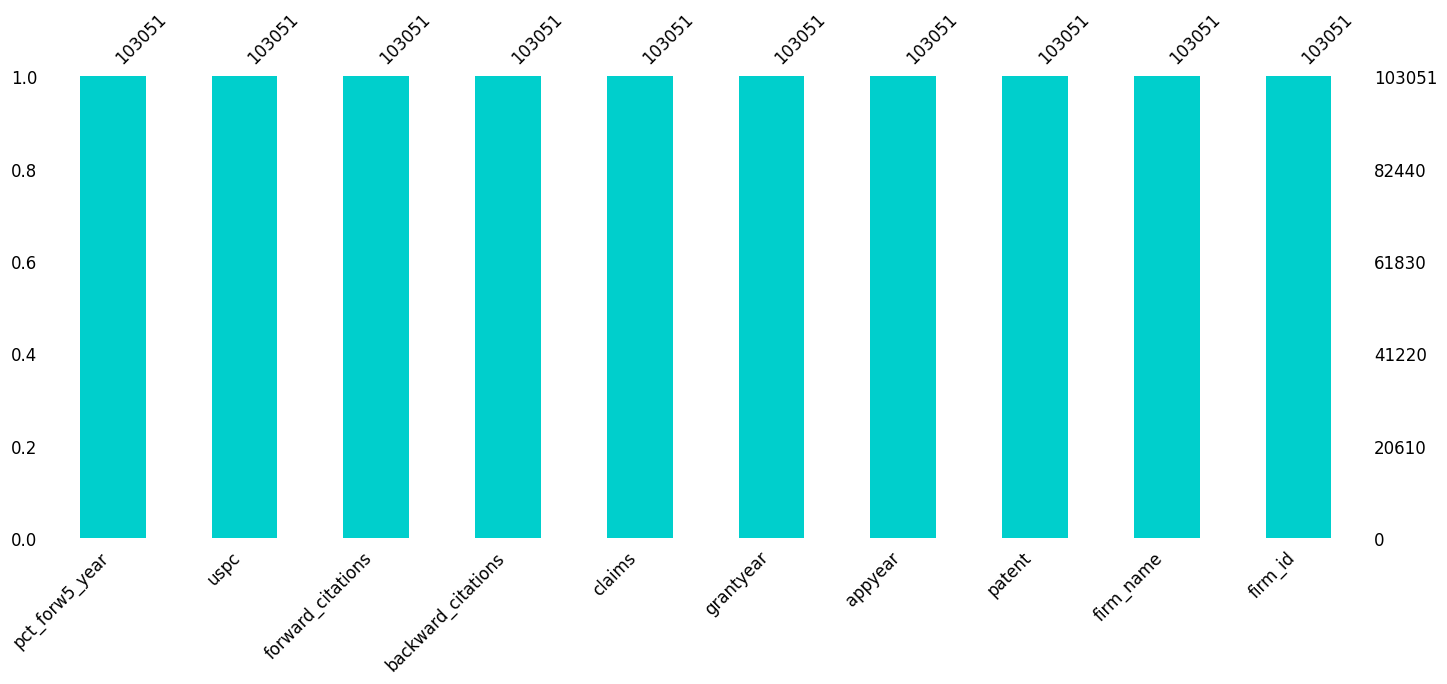

In [6]:
# Bar plot of missing values and percentage
msno.bar(df, labels=True, figsize=(17,6), fontsize=12, sort="descending", color="#00cfcc")

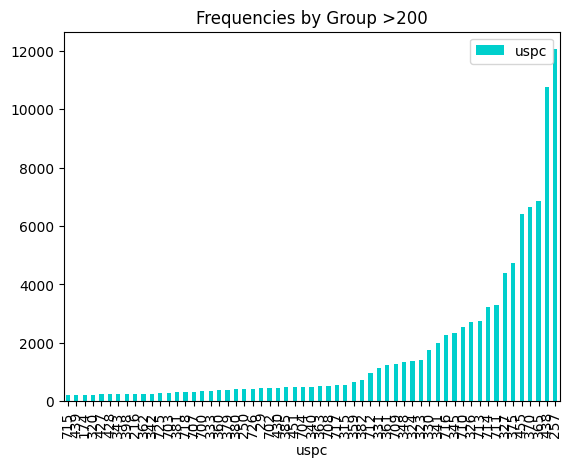

In [7]:
#Frequencies by group

# legend = list(np.unique(df.uspc))
# data = df['uspc'].value_counts().reset_index().sort_values(by = 'uspc')
# data.plot.bar(x='index', y='uspc', color ="#00cfcc") 
# plt.xlabel('uspc')
# plt.title(r'Frequencies by Group')

legend = list(np.unique(df.uspc))
data = df['uspc'].value_counts().reset_index().sort_values(by='uspc')
data = data.query('uspc > 200')  # filter frequencies higher than 100
data.plot.bar(x='index', y='uspc', color='#00cfcc')
plt.xlabel('uspc')
plt.title(r'Frequencies by Group >200')
plt.show()

# Task 1

For each technology element **USPC** in Intel’s portfolio of patents, categorize the technology as either distinctive, background, niche, marginal

1. Compute average patenting frequency per USPC class (industry level)
2. Compute average patenting frequency per USPC class (Intellevel)
3. Compare each USPC patented by Intel with these two thresholds & categorize USPC classes accordingly

## 1.1. Create a dataframe for the industry - Frequency Per USPC

In [9]:
industry = df.where(df["firm_name"] != "intel corp").dropna()
group_count_industry= industry[["uspc"]].groupby("uspc", as_index = False).size()
group_count_industry = group_count_industry.rename(columns={"size":"industry_frequency"})
group_count_industry= pd.DataFrame(group_count_industry)
group_count_industry

##Another way to do this could be:
# group_count_industry = industry["uspc"].value_counts().reset_index()
# group_count_industry = group_count_industry.rename(columns={"index": "uspc", "uspc": "industry_frequency"})
# group_count_industry

,uspc,industry_frequency
0,1,1
1,100,2
2,101,24
3,102,1
4,104,3
...,...,...
355,96,2
356,977,10
357,99,1
358,D8,1


## 1.2. Get industry frequency mean (Coordinate origin for Y axis)

In [10]:
mean_industry = group_count_industry["industry_frequency"].mean()
mean_industry

237.12777777777777

## 2.1. Create a dataframe for the industry - Frequency Per USPC

In [11]:
intel = df.where(df["firm_name"] == "intel corp").dropna()
group_count_intel = intel[["uspc"]].groupby("uspc", as_index = False).size()
group_count_intel = group_count_intel.rename(columns={"size":"intel_frequency"})
group_count_intel= pd.DataFrame(group_count_intel)
group_count_intel

,uspc,intel_frequency
0,100,1
1,101,5
2,106,6
3,117,4
4,118,6
...,...,...
225,89,1
226,95,2
227,977,13
228,985,1


## 2.2. Get intel frequency mean (Coordinate origin for X axis)

In [12]:
mean_intel = group_count_intel["intel_frequency"].mean()
mean_intel

76.8913043478261

## 3.1 Merge the two dataset (Intel and Industry Frequencies)

In [13]:
Result = pd.merge(group_count_industry, 
    group_count_intel, 
    on = 'uspc',
    how ='outer')

# Calculate means
mean_industry = Result['industry_frequency'].mean()
mean_intel = Result['intel_frequency'].mean()

print(mean_industry)
print(mean_intel)

237.12777777777777
76.8913043478261


## 3.2 Classify the results

In [14]:
niche = Result.where((Result["industry_frequency"] >= mean_industry) & (Result["intel_frequency"] < mean_intel)).dropna()
distinctive_technologies = Result.where((Result["industry_frequency"] >= mean_industry) & (Result["intel_frequency"] >= mean_intel)).dropna()
marginal = Result.where((Result["industry_frequency"] < mean_industry) & (Result["intel_frequency"] < mean_intel)).dropna()
background_knowledge = Result.where(( Result["industry_frequency"] <= mean_industry) & (Result["intel_frequency"] > mean_intel)).dropna()

## 3.3. Add a column to the dataframe to classify

In [15]:
# Create the new column
Result["category"] = ""

# Assign the categories to the new column
Result.loc[niche.index, "category"] = "niche"
Result.loc[distinctive_technologies.index, "category"] = "distinctive_technologies"
Result.loc[marginal.index, "category"] = "marginal"
Result.loc[background_knowledge.index, "category"] = "background_knowledge"

# Show the final dataframe with the new column
Result

,uspc,industry_frequency,intel_frequency,category
0,1,1.0,NaN,
1,100,2.0,1.0,marginal
2,101,24.0,5.0,marginal
3,102,1.0,NaN,
4,104,3.0,NaN,
...,...,...,...,...
392,808,NaN,1.0,
393,846,NaN,1.0,
394,89,NaN,1.0,
395,985,NaN,1.0,


## 3.3 Plot the classification

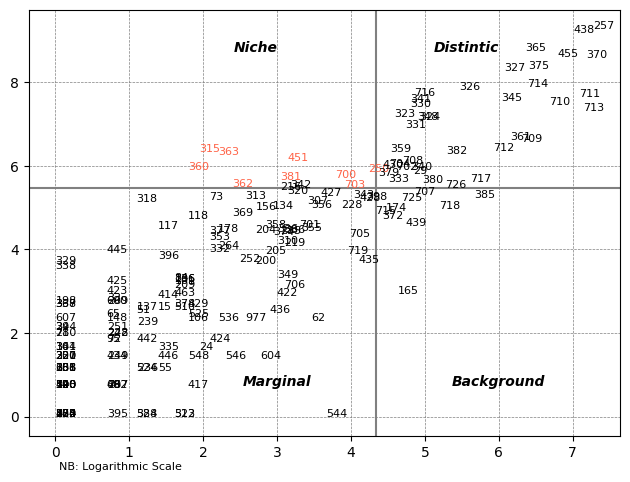

In [16]:
fig, ax = plt.subplots() 

# Axes

ax.axhline(y= np.log(mean_industry), color='grey')  # Applying logarithmic transformation to y-axis
ax.axvline(x= np.log(mean_intel), color='grey')     # Applying logarithmic transformation to x-axis
ax.grid(color='grey', linestyle='--', linewidth=0.5, which ="major")

scatter = ax.scatter(np.log(Result.intel_frequency), np.log(Result.industry_frequency), color="#FFFFFF")  # Applying logarithmic transformation to data

# Annote the quedrants 

ax.text((0*np.log(mean_intel))+3, (0*(np.log(mean_industry))+9), 'Niche', ha='right', va='top', fontstyle= "oblique",  weight='bold')
ax.text((0*np.log(mean_intel))+6, (0*(np.log(mean_industry))+9), 'Distintic', ha='right', va='top', fontstyle= "oblique",  weight='bold')
ax.text((0*np.log(mean_intel))+3, (0*(np.log(mean_industry))+1), 'Marginal', ha='center', va='top', fontstyle= "oblique",  weight='bold')
ax.text((0*np.log(mean_intel))+6, (0*(np.log(mean_industry))+1), 'Background', ha='center', va='top', fontstyle= "oblique",  weight='bold')

# Name each point 
for i, name in enumerate(Result.uspc):
     if np.isfinite(Result.intel_frequency[i]) and np.isfinite(Result.industry_frequency[i]):
            color = "tomato" if Result.category[i] == "niche" else "black"
            ax.text(np.log(Result.intel_frequency[i]), np.log(Result.industry_frequency[i]), name, fontsize=8, color=color)  # Applying logarithmic transformation to data


plt.figtext(0.1, 0.01, "NB: Logarithmic Scale", fontsize=8)
# Show graph 
fig.tight_layout()
plt.show()


## 3.3.1 Plot quadrant per quadrant

In [17]:
niche

,uspc,industry_frequency,intel_frequency
82,250,347.0,69.0
128,315,565.0,7.0
171,360,367.0,6.0
173,362,245.0,11.0
174,363,524.0,9.0
193,381,286.0,21.0
240,451,458.0,23.0
307,700,304.0,44.0
310,703,241.0,50.0


In [18]:
niche.reset_index(inplace=True)
distinctive_technologies.reset_index(inplace=True)
marginal.reset_index(inplace=True)
background_knowledge.reset_index(inplace=True)

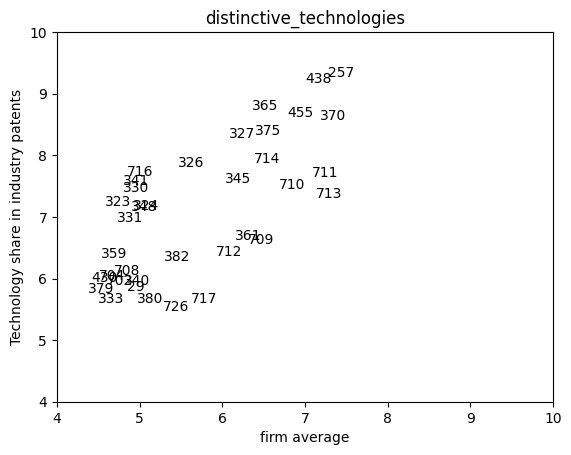

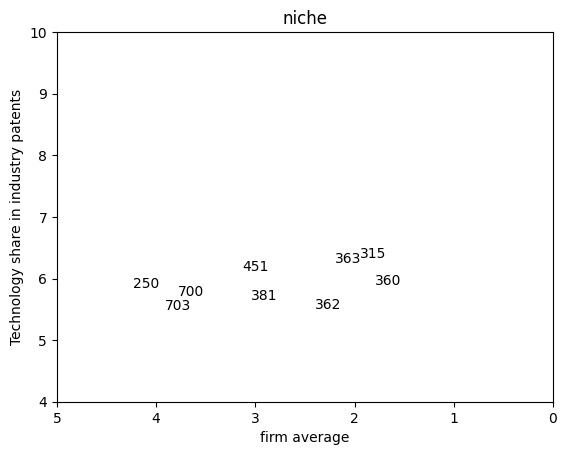

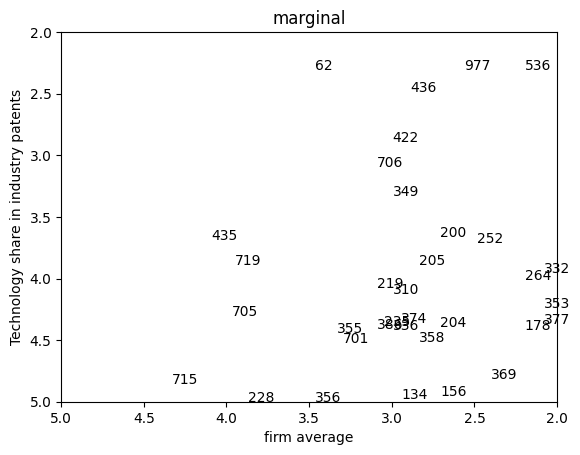

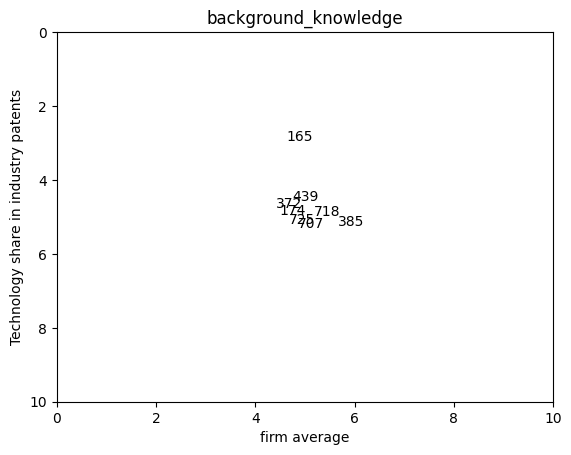

In [19]:
# # distinctive_technologies
fig, ax = plt.subplots()
ax.scatter(np.log(distinctive_technologies["intel_frequency"]), np.log(distinctive_technologies["industry_frequency"]), color="#FFFFFF")

for i, txt in enumerate(distinctive_technologies['uspc']):
    ax.annotate(txt, (np.log(distinctive_technologies["intel_frequency"])[i], np.log(distinctive_technologies["industry_frequency"])[i]))

plt.xlabel("firm average")
plt.ylabel("Technology share in industry patents")
plt.title("distinctive_technologies")
plt.ylim(4, 10)
plt.xlim(4,10)
plt.show()

## niche

fig, ax = plt.subplots()
ax.scatter(np.log(niche["intel_frequency"]), np.log(niche["industry_frequency"]), color="#FFFFFF")

for i, txt in enumerate(niche['uspc']):
    ax.annotate(txt, (np.log(niche["intel_frequency"])[i], np.log(niche["industry_frequency"])[i]))

plt.xlabel("firm average")
plt.ylabel("Technology share in industry patents")
plt.title("niche")
plt.ylim(4, 10)
plt.xlim(5,0)
plt.show()

## marginal

fig, ax = plt.subplots()
ax.scatter(np.log(marginal["intel_frequency"]), np.log(marginal["industry_frequency"]), color="#FFFFFF")

for i, txt in enumerate(marginal['uspc']):
    ax.annotate(txt, (np.log(marginal["intel_frequency"])[i], np.log(marginal["industry_frequency"])[i]))

plt.xlabel("firm average")
plt.ylabel("Technology share in industry patents")
plt.title("marginal")
plt.ylim(5,2)
plt.xlim(5,2)
plt.show()


# # background_knowledge

fig, ax = plt.subplots()
ax.scatter(np.log(background_knowledge["intel_frequency"]), np.log(background_knowledge["industry_frequency"]), color="#FFFFFF")

for i, txt in enumerate(background_knowledge['uspc']):
    ax.annotate(txt, (np.log(background_knowledge["intel_frequency"])[i], np.log(background_knowledge["industry_frequency"])[i]))

plt.xlabel("firm average")
plt.ylabel("Technology share in industry patents")
plt.title("background_knowledge")
plt.xlim(0,10)
plt.ylim(10,0)
plt.show()

# Task 2

Identify among USPC classes in niche, identify those characterized by more valuable and risky projects
I. Compute average patent value (to measure quality) and standard deviation (to measure risk) on a composite index of claims, forward citations and 1/backward citations in each USPC class (Intel level)
II. Rankclassesbytheseindicators

In [20]:
# Identify among USPC classes in niche, identify those characterized by more valuable and risky projects
uspc_niche = niche["uspc"]
data_niche = intel[intel['uspc'].isin(uspc_niche)]

patent_value = data_niche[["uspc","claims","forward_citations","backward_citations"]]
patent_value["1/backward_citations"] = 1/patent_value["backward_citations"]
#It gives infinite values as we have backward_citations = 0 sometimes.
patent_value["1/backward_citations"].replace([np.inf, -np.inf], np.nan, inplace=True)
patent_value = patent_value.dropna(axis=0)
#So we have decided to remove them
patent_value["patent_value_lc"] = patent_value["1/backward_citations"] + patent_value["forward_citations"] + patent_value["claims"]
#Then, we do the sum of these 3 indicators


avg_patent_value= round(patent_value[["uspc", "patent_value_lc"]].groupby("uspc", as_index = False).mean(),2)
std_patent_value = round(patent_value[["uspc", "patent_value_lc"]].groupby("uspc", as_index = False).std(),2)

columns = [avg_patent_value, std_patent_value]

uspc_niche = pd.DataFrame(uspc_niche)
for i in columns:
    uspc_niche = pd.merge(uspc_niche, 
        i,
        on = 'uspc',
        how ='left')

uspc_niche

/tmp/ipykernel_343/3759053142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patent_value["1/backward_citations"] = 1/patent_value["backward_citations"]
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,uspc,patent_value_lc_x,patent_value_lc_y
0,250,23.28,12.80
1,315,21.68,11.59
2,360,42.99,38.05
3,362,27.67,21.52
4,363,29.66,12.64
5,381,25.32,12.23
6,451,22.88,15.78
7,700,26.65,11.36
8,703,25.30,13.49


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7d6f8588-025b-4e36-ba14-1ed9a80be2cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>